In [2]:
%config InlineBackend.figure_formats=['svg']
import numpy as np
import scipy
import scipy.sparse as sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import only_prop_change_of_referential as api
import time
import math

np.random.seed(0)

In [3]:
N_omega = 21
free_indices = 2*N_omega - 1 - 12
omega = np.linspace(-10, 10, N_omega)
delta_omega = np.abs(omega[1] - omega[0])
N_z = 5
z = np.linspace(0, 1., N_z)
delta_z = np.abs(z[1] - z[0])
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [4]:
beta_vec = np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2/4.)#3*(np.random.random(2*N_omega - 1) - 0.5*np.ones(2*N_omega - 1))#
#np.array(list((0.1/decay_curve)*np.exp(np.linspace(0, position*delta_omega, position))) + list(0.1 + np.exp(-np.linspace(omega[position], omega[len(omega) - 1 - position], 2*N_omega - 1 - 2*position)**2)) + list((0.1/decay_curve)*np.exp(np.linspace(position*delta_omega, 0, position))))
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = delta_omega*beta/(np.sqrt(np.trace(beta@beta)))
# Try for n = 0.5
beta_weight = 2.145#0.02531#1.631#0.110747#663.61#1.30664#1.0868#
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
n = 0.25*np.trace((scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])).conj().T@(scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])))
change_ref = scipy.linalg.svd(scipy.linalg.expm(Q_plus*z[-1]))[2].conj().T@scipy.linalg.svd(scipy.linalg.expm(Q_plus*z[-1]))[0].conj().T
W_plus = [(1/np.sqrt(n))*change_ref@scipy.linalg.expm(Q_plus*z[i]) for i in range(0, N_z)]
W_minus = [(1/np.sqrt(n))*change_ref@scipy.linalg.expm(Q_minus*z[i]) for i in range(0, N_z)]
X = np.vstack(W_plus + W_minus + [new_beta])
Y = np.vstack(W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T
n

(1.0000948401885164+0j)

In [5]:
# Tests on the theoretical matrices
sum(scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1])

2.9878134313757907

In [6]:
# Test for the dynamics, matrix form
green_fs = api.get_green_f(omega, z)
green_fs.reverse()
approx = 0.5*delta_z*beta_weight*(new_beta@(W_plus[-1].conj().T + W_minus[-1].conj().T) + green_fs[0].conj().T@new_beta@(W_plus[0].conj().T + W_minus[0].conj().T))
for i in range(1,len(green_fs) - 1):
    approx += delta_z*beta_weight*green_fs[i].conj().T@new_beta@(W_plus[i].conj().T + W_minus[i].conj().T)
theory = (W_plus[-1] - W_minus[-1]).conj().T
np.max(np.abs(np.real(approx - theory))), np.max(np.abs(np.imag(approx - theory)))

(0.0844416721119588, 0.10167842018579777)

In [7]:
# Test for dynamics, element wise
# Be very careful about not inverting x_label and y_label, since the propagators not symmetric anymore
proj = projections[301]
end = 2
green_fs = api.get_green_f(omega, z[:end])
green_fs.reverse()
approx_plus = 0.5*delta_z*beta_weight*np.trace(proj@new_beta@W_plus[end - 1].conj().T + proj@green_fs[0].conj().T@new_beta@W_plus[0].conj().T)
approx_minus = 0.5*delta_z*beta_weight*np.trace(proj@new_beta@W_minus[end - 1].conj().T + proj@green_fs[0].conj().T@new_beta@W_minus[0].conj().T)
for i in range(1, end - 1):
    approx_plus += delta_z*beta_weight*np.trace(proj@green_fs[i].conj().T@new_beta@W_plus[i].conj().T)
    approx_minus += delta_z*beta_weight*np.trace(proj@green_fs[i].conj().T@new_beta@W_minus[i].conj().T)
mats = api.get_dynamics_matrices(omega, z, beta_weight, proj)
np.trace(mats[0]@Y@Y.conj().T) + 1.j*np.trace(mats[1]@Y@Y.conj().T), approx_plus + approx_minus - np.trace(proj@(W_plus[end - 1] - W_minus[end-1]))

((0.01882023076462268+0.013904567304909151j),
 (0.03733771686892763-0.049897272019453875j))

In [9]:
# Tests for inequalities on the trace of U_plus_N and U_minus_N as well as the minimum eigenvalues
epsilon = 0.02
upper_bound_plus = 1 + np.sqrt(1 + 1/n) + epsilon/2 + np.sqrt(epsilon**2/4 + 1/n) + (N_omega - 2)/np.sqrt(n)
lower_bound_plus = 1 + np.sqrt(1 + 1/n) - epsilon/2 + np.sqrt(epsilon**2/4 + 1/n) + (N_omega - 2)/np.sqrt(n)
upper_bound_minus = -0.99 + np.sqrt(1 + 1/n) + epsilon/2 + np.sqrt(epsilon**2/4 + 1/n) + (N_omega - 2)/np.sqrt(n)
lower_bound_minus = -0.99 + np.sqrt(1 + 1/n) - epsilon/2 + np.sqrt(epsilon**2/4 + 1/n) + (N_omega - 2)/np.sqrt(n)
np.trace(W_plus[-1]), upper_bound_plus, lower_bound_plus, np.trace(W_minus[-1]), upper_bound_minus, lower_bound_minus

((22.301673403510264-8.26935502393916e-16j),
 (22.423281700775526+0j),
 (22.403281700775526+0j),
 (20.539695848930382+7.336259982293356e-15j),
 (20.433281700775524+0j),
 (20.413281700775524+0j))

In [10]:
# Gives the matrices to isolate needed porpagators
left_last_plus, right_last_plus = api.isolate_propagators(N_omega, N_z, N_z, "plus")
left_last_minus, right_last_minus = api.isolate_propagators(N_omega, N_z, N_z, "minus")
left_first_plus, right_first_plus = api.isolate_propagators(N_omega, N_z, 1, "plus")
left_first_minus, right_first_minus = api.isolate_propagators(N_omega, N_z, 1, "minus")

In [11]:
# Build the constraints
beta_weight = 0.17
n = 1.
dynamics_constraints = []
sympl_constraints = []
hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
imag_pump_constr = api.real_pump_constr(N_omega, N_z)
photon_nbr_constr = api.photon_nbr_constr(N_omega, N_z, n)
photon_nbr_constr_prev = api.photon_nbr_prev_points(N_omega, N_z)
for proj in projections:
    dynamics_constraints += api.get_dynamics_matrices(omega, z, beta_weight, proj)
    sympl_constraints += api.sympl_constr_sdr(N_omega, N_z, proj, n)
constraints_list = dynamics_constraints + sympl_constraints + hankel_constr + imag_pump_constr + [photon_nbr_constr]

In [12]:
# Build matrix for hermite basis and the matrices to isolate the pump
max_order = 2
width = 4.
herm_mat = api.get_hermite_polynom_mat(omega, max_order, width)

In [15]:
[np.trace(constraints_list[i]@Y@Y.conj().T) for i in range(len(dynamics_constraints), len(constraints_list)) if np.real(np.trace(constraints_list[i]@Y@Y.conj().T)) > 10**-8]

[]

In [58]:
[np.trace(photon_nbr_constr_prev[i]@Y@Y.conj().T) for i in range(len(photon_nbr_constr_prev))]

[(0.17155851188465654+0j),
 (0.2218336839467815+0j),
 (0.27604540381829185+0j),
 (0.3305624003502727+0j)]

In [16]:
# Build cvxpy model
var = cp.Variable(shape=(((2*N_z + 2)*N_omega,(2*N_z + 2)*N_omega)), hermitian = True)
hermite_coeff = cp.Variable(shape=(max_order,))
# Get the isolated U_plus_0, U_minus_0, U_plus_N and U_minus_N
U_plus_N = left_last_plus.conj().T@var@right_last_plus
U_minus_N = left_last_minus.conj().T@var@right_last_minus
U_plus_0 = left_first_plus.conj().T@var@right_first_plus
U_minus_0 = left_first_minus.conj().T@var@right_first_minus
# Set the constraints
constraints = [var >> 0]
constraints += [cp.real(cp.trace(constraints_list[i]@var)) == 0 for i in range(len(constraints_list))]
# Set the inequality constraints
constraints += [cp.real(cp.trace(photon_nbr_constr_prev[i]@var)) >= 0 for i in range(len(photon_nbr_constr_prev))]
# Gives the constraints that U_plus_N and U_minus_N are Hermitian
constraints.append(U_plus_N>>0)
constraints.append(U_minus_N>>0)
# Gives the constraint that U_plus_0 = U_minus_0
constraints.append(U_plus_0 == U_minus_0)
# Add constraints on the trace of U_plus_N and U_minus_N (lower and upper ineq) and max and in eigvals of both propagators
constraints.append(cp.real(upper_bound_plus) >= cp.real(cp.trace(U_plus_N)))
constraints.append(cp.real(upper_bound_minus) >= cp.real(cp.trace(U_minus_N)))
constraints.append(cp.real(cp.trace(U_plus_N)) >= cp.real(lower_bound_plus))
constraints.append(cp.real(cp.trace(U_minus_N)) >= cp.real(lower_bound_minus))

# Hermite basis constraint
left_first_pump, left_second_pump, right_first_pump, right_second_pump = api.isolate_vect_pump(N_omega, N_z)
constraints.append(cp.real(cp.hstack([left_first_pump.conj().T@var@right_first_pump, left_second_pump.conj().T@var@right_second_pump])) == herm_mat.T@hermite_coeff)

# Objective function
# Change the trace into nuclear norm
problem = cp.Problem(cp.Minimize(cp.real(cp.norm(U_plus_N - U_minus_N, "nuc"))), constraints)

In [17]:
problem.solve(cp.MOSEK, verbose = True, mosek_params = {"MSK_IPAR_INTPNT_MAX_ITERATIONS":10**9, "MSK_DPAR_INTPNT_CO_TOL_INFEAS":10**-8, "MSK_IPAR_NUM_THREADS":8, "MSK_DPAR_INTPNT_CO_TOL_DFEAS":10**-4, "MSK_DPAR_INTPNT_CO_TOL_PFEAS":10**-4, "MSK_DPAR_INTPNT_TOL_DFEAS":10**-4})

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jun 24 08:41:07 PM: Your problem has 63506 variables, 8393 constraints, and 0 parameters.
(CVXPY) Jun 24 08:41:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 24 08:41:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 24 08:41:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 24 08:41:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 24 08:41:07 PM: Compiling problem (target solver=MOSEK

1.9700000000000906

In [20]:
# Get the important blocks from solution
end_product = var.value
U_plus = [end_product[(2*N_z + 1)*N_omega:, i*N_omega:(i + 1)*N_omega] for i in range(N_z)]
U_minus = [end_product[(2*N_z + 1)*N_omega:, (N_z + i)*N_omega:(N_z + i + 1)*N_omega] for i in range(N_z)]
VU_plus = [end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z)]
VU_minus = [end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, (N_z + i)*N_omega:(N_z + i + 1)*N_omega] for i in range(N_z)]
quad_U_plus = [end_product[i*N_omega:(i + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z)]
quad_U_minus = [end_product[(N_z + i)*N_omega:(N_z + i + 1)*N_omega, (N_z + i)*N_omega:(N_z + i + 1)*N_omega] for i in range(N_z)]
opt_pump = end_product[(2*N_z + 1)*N_omega:, 2*N_z*N_omega:(2*N_z + 1)*N_omega]

In [23]:
# See what VU_+ looks like and see what matshow of U_plus abs looks like
VU_plus[-1]

array([[ 1.00996862e-01-2.49309064e-08j, -9.47668614e-07-1.69436621e-06j,
        -5.24988735e-05-4.09441959e-06j,  2.95025445e-07-2.32272756e-06j,
        -4.32195462e-05-3.52111215e-06j,  1.40533383e-07-5.60373592e-07j,
        -3.09053422e-05-1.15355130e-06j, -6.82566513e-07+8.41801126e-08j,
        -1.74768616e-05-6.99099414e-07j,  4.16335635e-07+2.87698575e-07j,
        -5.77098221e-07-6.52903123e-07j,  1.68201720e-05+2.46865843e-07j,
         5.51786559e-05-9.18067394e-08j,  1.30539683e-04-6.90144728e-08j,
         3.06257936e-04+2.06983231e-07j,  5.86393795e-04-1.49910054e-06j,
         1.04379477e-03-1.23379688e-06j,  1.59150868e-03-3.44213750e-06j,
         2.19372653e-03-2.18231976e-06j,  2.62748328e-03-6.54834298e-06j,
         2.82012745e-03-1.08954266e-05j],
       [-1.01487919e-06+9.50094444e-07j,  1.00949154e-01-2.72442715e-07j,
        -1.25560979e-06-1.90053278e-06j, -8.75834942e-05-5.58688263e-06j,
        -2.18995500e-07-2.11178132e-06j, -6.32632298e-05-4.55316573e-0

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


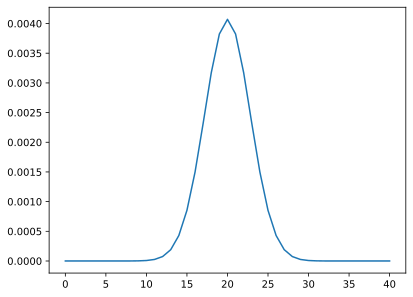

In [69]:
plt.plot(list(opt_pump[0]) + list(opt_pump[-1][1:]))

In [1]:
sum(scipy.linalg.svd(U_plus[-1])[1]), upper_bound_plus, lower_bound_plus, sum(scipy.linalg.svd(U_minus[-1])[1]), upper_bound_minus, lower_bound_minus

NameError: name 'scipy' is not defined

In [33]:
sum(scipy.linalg.svd(W_plus[-1])[1])

22.30167340351026